# Get Data

In [ ]:
import requests
import pandas as pd
import numpy as np

In [ ]:
params = {
    "queryly_key": "31a35d40a9a64ab3",
    "query": "disney", # pepsico, american airlines
    "endindex": "0",
    "batchsize": "100",
    "callback": "",
    "showfaceted": "true",
    "timezoneoffset": "-120",
    "facetedfields": "formats",
    "facetedkey": "formats|",
    "facetedvalue":
    "!Press Release|",
    "needtoptickers": "1",
    "additionalindexes": "4cd6f71fbf22424d,937d600b0d0d4e23,3bfbe40caee7443e,626fdfcd96444f28"
}

goal = ["cn:title", "_pubDate", "section", "cn:liveURL", "summary"]
test = []
def main(url):
    with requests.Session() as req:
        allin = []
        for page, item in enumerate(range(0, 11000, 100)):
            params["endindex"] = item
            r = req.get(url, params=params).json()
            test.append(r)
            for loop in r['results']:
                try:
                    allin.append([loop[x] for x in goal])
                except:
                    pass
        new = pd.DataFrame(allin, columns=["Title", "Date", "Section", "Url", "Summary"])
        return new

# df = main("https://api.queryly.com/cnbc/json.aspx")

# Sentimental Analysis

DIS: 2010-6/2015, 6/2015-6/2017, 6/2017-6/2019, 6/2019-2021<br>
AAL: 2013 - 2015, 2015-2019, 2019-2020, 2020-2021<br>
PEP: 2010-6/2011, 6/2011-6/2013, 6/2013-6/2015, 6/2015-2018, 2018-2019, 2019-2021<br>

In [1]:
import pandas as pd
import numpy as np
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
import pprint
import nltk
from nrclex import NRCLex
import re
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from collections import OrderedDict
from operator import itemgetter

%matplotlib inline
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import sys
import warnings
if not sys.warnoptions: warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [43]:
# Lower all texts 
# Remove all digits 
# Remove all punctuations 
# Remove string start with xx+ 

def text_process(t): 
    if isinstance(t, str): 
        t = t.lower()
        t = re.sub(r'[0-9]', '', t) 
        t = re.sub('[,\.!?/#!@$%^&*:_]', ' ', t) 
        t = t.strip() 
        return t 
    else: return "" 

def sentimental_analysis(df, col):
    def score(t):
        text_object = NRCLex(t)
        score_list = text_object.top_emotions

        def Convert(tup, di): return dict(tup)
        
        dictionary = {}
        di = Convert(score_list, dictionary)
        return di
    
    df['sentimental_raw'] = df[col].apply(lambda x: score(x))
    
    def one_hot(df, senti):
        df[senti] = df['sentimental_raw'].apply(lambda x: x.get(senti) if (senti in x.keys()) else 0.0)
        return df
    
    sent_list = ['fear','anger','anticip','trust','surprise','positive','negative','sadness','disgust','joy']
    for s in sent_list: df = one_hot(df,s)
    
    return df

# https://towardsdatascience.com/generate-meaningful-word-clouds-in-python-5b85f5668eeb
def wordcloud(df, word_set):
    text = ' '.join(df['clean_data'])
    wordcloud = WordCloud(stopwords=STOPWORDS.union(word_set), background_color='white', width=9000, height=6000).generate(text)
    text_dictionary = wordcloud.process_text(text)
    word_freq = {k: v for k, v in sorted(text_dictionary.items(),reverse=True, key=lambda item: item[1])}
    print(list(word_freq.items())[:50])
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
    l = list(word_freq.items())[:100]
    m = pd.DataFrame(l, columns =['word', 'freq'])
    
    return m

In [44]:
aal = pd.read_csv('aa_cnbc.csv')
pep = pd.read_csv('pepsico_cnbc.csv')
dis = pd.read_csv('disney_cnbc.csv')

print(len(dis))
print(len(aal))
print(len(pep))

10482
6767
2638


## Disney Sentimental

In [45]:
dis['clean_data'] = dis['Title'].apply(lambda x: text_process(x))
senti_dis = sentimental_analysis(dis, 'clean_data')
senti_dis.head(1)

,Unnamed: 0,Title,Date,Section,Url,Summary,clean_data,sentimental_raw,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy
0,0,Disney raises price of ESPN+ by a dollar to $6...,7/12/2021 10:21:08 PM,Technology,https://www.cnbc.com/2021/07/12/disney-raises-...,"Disney raises price of ESPN+ by a dollar, keep...",disney raises price of espn+ by a dollar to ...,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
senti_dis.to_pickle("./Data/dis_cnbc_senti.pkl")

In [29]:
for i in ['fear','anger','anticip','trust','surprise','positive','negative','sadness','disgust','joy']:
    print(f"0-score % of {i}: {len(senti_dis[senti_dis[i]==0])/len(senti_dis[i])}.")

0-score % of fear: 0.8821789734783438.
0-score % of anger: 0.9210074413279908.
0-score % of anticip: 1.0.
0-score % of trust: 0.8008967754245373.
0-score % of surprise: 0.8991604655600076.
0-score % of positive: 0.6229727151307003.
0-score % of negative: 0.7051135279526808.
0-score % of sadness: 0.9266361381415761.
0-score % of disgust: 0.9698530814730013.
0-score % of joy: 0.8969662278191185.


[('netflix', 553), ('new', 408), ('ceo', 344), ('earning', 327), ('dow', 282), ('market', 279), ('deal', 268), ('stock', 262), ('making', 262), ('apple', 262), ('buy', 247), ('cramer', 236), ('year', 236), ('big', 226), ('top', 222), ('us', 222), ('box office', 211), ('biggest move', 211), ('media', 209), ('million', 200), ('wall street', 200), ('day', 195), ('week', 192), ('billion', 188), ('comcast', 187), ('investor', 185), ('fox', 182), ('rise', 176), ('gain', 176), ('may', 175), ('analyst', 171), ('tv', 169), ('movie', 164), ('trump', 159), ('best', 158), ('tech', 155), ('now', 154), ('amazon', 150), ('ahead', 146), ('early movers', 145), ('make', 141), ('bob iger', 140), ('watch', 139), ('close', 139), ('fall', 135), ('espn', 134), ('rally', 134), ('streaming service', 133), ('time', 132), ('stock market', 132)]


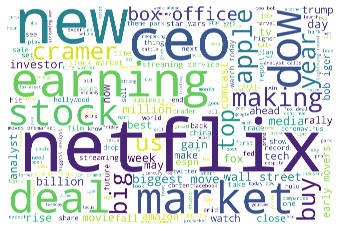

In [46]:
word_set = {'https','t','co','disney','says','dis','s','p','u','m','q','th','vs','k','t','c','stocks','say','will'}
m = wordcloud(senti_dis, word_set)

In [47]:
m.to_csv('dis_freq.csv')

### 201001 - 201506

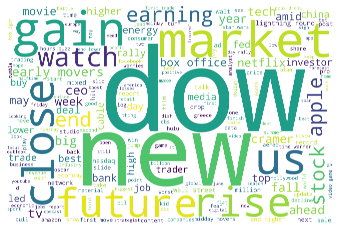

In [172]:
df = pd.read_pickle("./Data/dis_1001_1506.pkl")
word_set = {'https','t','co','disney','says','dis','s','p','u','m','q','th','vs','k','t','c','stocks','say','will'}
wordcloud(df, word_set)

### 201506 - 201706

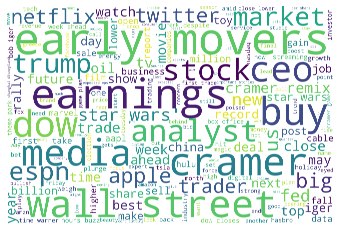

In [173]:
df = pd.read_pickle("./Data/dis_1506_1706.pkl")
word_set = {'https','t','co','disney','dis','says','s','p','u','m','q','th','vs','k','t','c','stocks','say','will'}
wordcloud(df, word_set)

### 201706 - 201906

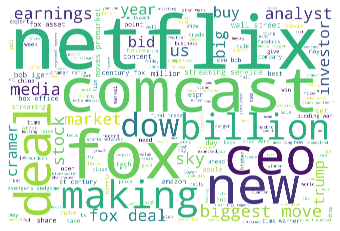

In [174]:
df = pd.read_pickle("./Data/dis_1706_1906.pkl")
word_set = {'https','t','co','disney','dis','says','s','p','u','m','q','th','vs','k','t','c','say','will','stocks'}
wordcloud(df, word_set)

### 201906 - 202107

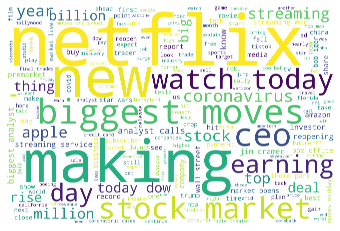

In [175]:
df = pd.read_pickle("./Data/dis_1906_2107.pkl")
word_set = {'https','t','co','disney','dis','says','s','p','u','m','q','th','vs','k','t','c','say','will','stocks'}
wordcloud(df, word_set)

## American Airline Sentimental

In [50]:
aal['clean_data'] = aal['Title'].apply(lambda x: text_process(x))
senti_aal = sentimental_analysis(aal, 'clean_data')
senti_aal.head(1)

,Unnamed: 0,Title,Date,Section,Url,Summary,clean_data,sentimental_raw,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy
0,0,Stocks making the biggest moves in the premark...,7/9/2021 1:49:28 PM,Market Insider,https://www.cnbc.com/2021/07/09/stocks-making-...,These are the stocks posting the largest moves...,stocks making the biggest moves in the premark...,"{'trust': 0.3333333333333333, 'positive': 0.33...",0.0,0.0,0.0,0.333333,0.0,0.333333,0.333333,0.0,0.0,0.0


In [89]:
senti_aal.to_pickle("./Data/aal_cnbc_senti.pkl")

In [19]:
for i in ['fear','anger','anticip','trust','surprise','positive','negative','sadness','disgust','joy']:
    print(f"0-score % of {i}: {len(senti_aal[senti_aal[i]==0])/len(senti_aal[i])}.")

0-score % of fear: 0.8427663661888577.
0-score % of anger: 0.911629968967046.
0-score % of anticip: 1.0.
0-score % of trust: 0.7886803605733708.
0-score % of surprise: 0.9153243682577213.
0-score % of positive: 0.6652874242648146.
0-score % of negative: 0.6324811585636175.
0-score % of sadness: 0.9060144820452194.
0-score % of disgust: 0.967784838185311.
0-score % of joy: 0.9199054233781587.


[('stock', 591), ('us', 360), ('flight', 271), ('new', 268), ('stocks making', 223), ('biggest move', 222), ('united', 217), ('boeing', 208), ('ceo', 203), ('travel', 196), ('will', 180), ('earning', 180), ('stock market', 170), ('coronavirus', 169), ('trump', 163), ('delta', 160), ('wall street', 138), ('point', 137), ('day', 134), ('week', 129), ('best', 128), ('early movers', 128), ('china', 123), ('oil', 121), ('watch today', 121), ('year', 119), ('billion', 116), ('top', 115), ('dow', 114), ('credit card', 112), ('gain', 109), ('rise', 107), ('cramer', 103), ('moves midday', 102), ('may', 100), ('back', 100), ('take', 99), ('southwest', 99), ('bank', 98), ('deal', 97), ('big', 96), ('market', 96), ('trade', 96), ('hit', 95), ('airport', 93), ('traveler', 93), ('fall', 92), ('apple', 92), ('plan', 92), ('passenger', 91)]


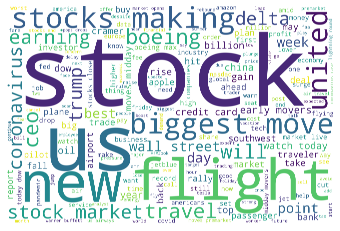

In [51]:
word_set = {'https','t','co','aal','says','american','airlines','airline','american airlines','american airline','s','p','u','m','q','th','vs','t','j'}
m = wordcloud(senti_aal, word_set)

In [52]:
m.to_csv('aal_freq.csv')

### 201301 - 201501

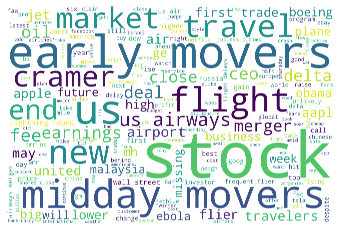

In [178]:
df = pd.read_pickle("./Data/aal_1301_1501.pkl")
word_set = {'https','t','co','aal','says','american','airlines','airline','american airlines','american airline','s','p','u','m','q','th','vs','t','j'}
wordcloud(df, word_set)

### 201501 - 201901

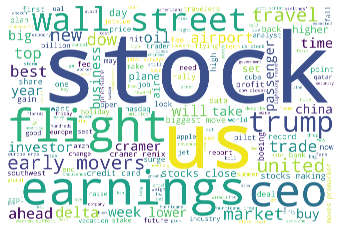

In [179]:
df = pd.read_pickle("./Data/aal_1501_1901.pkl")
word_set = {'https','t','co','aal','says','american','airlines','airline','american airlines','american airline','s','p','u','m','q','th','vs','t','j'}
wordcloud(df, word_set)

### 201901 - 202001

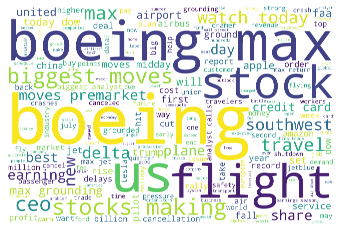

In [180]:
df = pd.read_pickle("./Data/aal_1901_2001.pkl")
word_set = {'https','t','co','aal','says','american','airlines','airline','american airlines','american airline','say','s','p','u','m','q','th','vs','t','j'}
wordcloud(df, word_set)

### 202001 - 202107

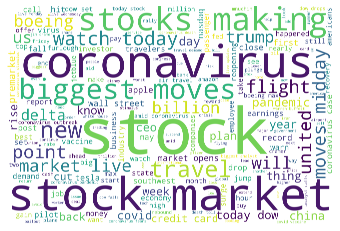

In [181]:
df = pd.read_pickle("./Data/aal_2001_2107.pkl")
word_set = {'https','t','co','aal','says','american','say','airlines','airline','american airlines','american airline','s','p','u','m','q','th','vs','t','j'}
wordcloud(df, word_set)

## PepsiCo Sentiment

In [53]:
pep['clean_data'] = pep['Title'].apply(lambda x: text_process(x))
senti_pep = sentimental_analysis(pep, 'clean_data')
senti_pep.head(1)

,Unnamed: 0,Title,Date,Section,Url,Summary,clean_data,sentimental_raw,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy
0,0,Watch CNBC's full interview with PepsiCo CFO o...,4/15/2021 2:23:07 PM,Squawk Box U.S.,https://www.cnbc.com/video/2021/04/15/pepsico-...,PepsiCo on Thursday reported quarterly earning...,watch cnbc's full interview with pepsico cfo o...,"{'fear': 0.3333333333333333, 'positive': 0.333...",0.333333,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0


In [183]:
senti_pep.to_pickle("./Data/pep_cnbc_senti.pkl")

In [22]:
for i in ['fear','anger','anticip','trust','surprise','positive','negative','sadness','disgust','joy']:
    print(f"0-score % of {i}: {len(senti_pep[senti_pep[i]==0])/len(senti_pep[i])}.")

0-score % of fear: 0.8779378316906747.
0-score % of anger: 0.9173616376042456.
0-score % of anticip: 1.0.
0-score % of trust: 0.8172858225928734.
0-score % of surprise: 0.9162244124336618.
0-score % of positive: 0.6569370735405611.
0-score % of negative: 0.6546626231993935.
0-score % of sadness: 0.9272175890826384.
0-score % of disgust: 0.9670204700530705.
0-score % of joy: 0.913570887035633.


[('stock', 393), ('cramer', 178), ('earning', 170), ('market', 135), ('ceo', 130), ('new', 107), ('coca cola', 92), ('future', 91), ('buy', 70), ('big', 68), ('dow', 67), ('top', 63), ('companies', 62), ('super bowl', 62), ('coke', 60), ('us', 59), ('investor', 56), ('fall', 53), ('week', 53), ('year', 51), ('gain', 51), ('rise', 50), ('higher', 49), ('rally', 48), ('sale', 48), ('food', 46), ('time', 46), ('watch', 45), ('wall street', 45), ('early movers', 45), ('beverage', 44), ('growth', 43), ('deal', 43), ('stocks making', 43), ('biggest move', 43), ('trade', 42), ('profit', 42), ('business', 41), ('cramer remix', 41), ('apple', 40), ('bank', 40), ('report', 40), ('brand', 38), ('consumer', 38), ('take', 38), ('stocks end', 38), ('tech', 37), ('ahead', 37), ('may', 37), ('company', 36)]


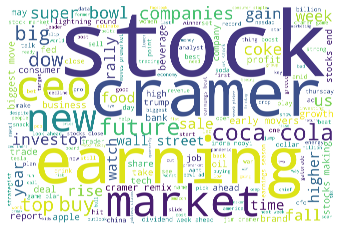

In [54]:
word_set = {'https','t','co','pepsico','pepsi','says','say','will','pep','s','p','u','m','q','th','vs','t','j'}
m = wordcloud(senti_pep, word_set)

In [55]:
m.to_csv('pep_freq.csv')

### 201001 - 201106

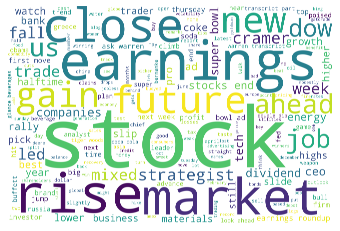

In [185]:
df = pd.read_pickle("./Data/pep_1001_1106.pkl")
word_set = {'https','t','co','pepsico','pepsi','says','say','will','pep','s','p','u','m','q','th','vs','t','j'}
wordcloud(df, word_set)

### 201106 - 201306

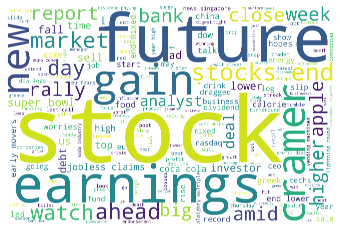

In [186]:
df = pd.read_pickle("./Data/pep_1106_1306.pkl")
word_set = {'https','t','co','pepsico','pepsi','say','says','will','pep','s','p','u','m','q','th','vs','t','j'}
wordcloud(df, word_set)

### 201306 - 201506

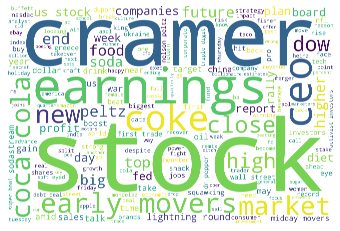

In [187]:
df = pd.read_pickle("./Data/pep_1306_1506.pkl")
word_set = {'https','t','co','pepsico','pepsi','say','says','will','pep','s','p','u','m','q','th','vs','t','j'}
wordcloud(df, word_set)

### 201506 - 201801

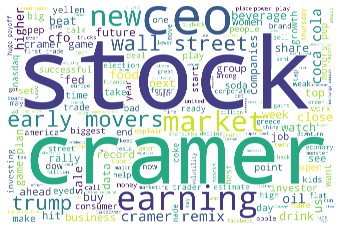

In [188]:
df = pd.read_pickle("./Data/pep_1506_1801.pkl")
word_set = {'https','t','co','pepsico','pepsi','say','says','will','s','p','u','m','q','th','vs','t','j'}
wordcloud(df, word_set)

### 201801 - 201901

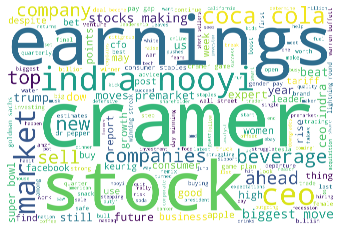

In [189]:
df = pd.read_pickle("./Data/pep_1801_1901.pkl")
word_set = {'https','t','co','pepsico','pepsi','say','says','will','pep','s','p','u','m','q','th','vs','t','j'}
wordcloud(df, word_set)

### 201901 - 202107

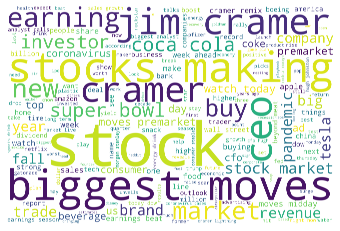

In [190]:
df = pd.read_pickle("./Data/pep_1901_2107.pkl")
word_set = {'https','t','co','pepsico','pepsi','say','says','will','pep','s','p','u','m','q','th','vs','t','j'}
wordcloud(df, word_set)

In [193]:
# pd.show_versions()